<a href="https://colab.research.google.com/github/RayBasilio123/R5/blob/master/INMET_DatasetR5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data treatment

In [ ]:
#imports
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
from datetime import timedelta
from datetime import datetime
import itertools
from statsmodels.tsa.arima_model import ARIMA
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import csv
import math

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# constantes
latitude = -22.89 #--em graus
longitude = -43.18  #--em graus
altitude = 11.10  #--em metros

In [ ]:
# configura o tamanho do grafico
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10,6

In [ ]:
#Recebe o arquivo csv
url= 'https://raw.githubusercontent.com/RayBasilio123/R5/master/inmet_pampulha_2018_2019.CSV'
df = pd.read_csv(url, sep=";", encoding = "ISO-8859-1").fillna(0)

In [ ]:
#Refaz o formato da hora
df['Hora'] = df['Hora'].str.replace(r'\D', '')
df['Hora'] = [x[:-2] for x in df['Hora']]

In [ ]:
#Acrescenta um 0 a esquerda em VENTO_VEL e substitui ',' por '.'
#df['VENTO_VEL'] = df['VENTO_VEL'].str.zfill(3)
df['VENTO_VEL'] = df['VENTO_VEL'].str.replace(',','.').fillna(0)

In [ ]:
#Substitui ',' por '.' em RADIACAO
df['RADIACAO'] = df['RADIACAO'].str.replace(',','.').fillna(0)

In [ ]:
#Substitui ',' por '.' em "PRESSAO_ATMOSFERICA" ao nivel da estação
df['PRESSAO_ATMOSFERICA'] = df['PRESSAO_ATMOSFERICA'].str.replace(',','.').fillna(0)

In [ ]:
# #Substitui os valores negativos de radiacao
df['RADIACAO'] = [float(x) for x in df['RADIACAO']]
df = df.assign(RADIACAO = df.RADIACAO.where(df.RADIACAO.ge(0))).fillna(0)

In [ ]:
# #replacing negative radiation values
# print(dataFrame.Rad.values.shape)

# for i in range(len(dataFrame['Rad'])):
#   dataFrame['te'][i] = float(dataFrame['Rad'][i]) if float(dataFrame['Rad'][i]) >= 0 else 0  




In [ ]:
#Substitui ',' por '.' em TEMPERATURA_MAX
df['TEMPERATURA_MAX'] = df['TEMPERATURA_MAX'].str.replace(',','.').fillna(0)

In [ ]:
#Substitui ',' por '.' em TEMPERATURA_MIN
df['TEMPERATURA_MIN'] = df['TEMPERATURA_MIN'].str.replace(',','.').fillna(0)

In [ ]:
# df.columns = ['data', 'hora','preciptacao','pressao','pressaoMax','pressaoMin','Rad','tem-ar','temp-orvalho','tempMax','tempMin','temp_Orv_Max','temp_Orv_Min','umidade_Max','umidade_Min','umidade_relativa','Vento_Direcao','Vento_Rajada','Velocidade_Vento','Unnamed']
# # df.head(-5)


In [ ]:
#Agrupa data+hora 
source_col_loc = df.columns.get_loc('Data') 
df['datetime'] = df.iloc[:,source_col_loc:source_col_loc+2].apply(
    lambda x: " ".join(x.astype(str)), axis=1)

In [ ]:
#Tranforma data+hora em Datetime e cria um novo dataframe
dataFormatada = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H')

d = {'date':dataFormatada, 'ventovel':df['VENTO_VEL'],'pressaoATM':df['PRESSAO_ATMOSFERICA'],'tempMax':df['TEMPERATURA_MAX'],'tempMin':df['TEMPERATURA_MIN'], 'umidade_Relativa':df['UMIDADE_RELATIVA_DO_AR'],'umi_Rel_Max':df['UMIDADE_REL_MAX'], 'umi_Rel_Min':df['UMIDADE_REL_MIN'],'Rad':df['RADIACAO']}

dataFrame = pd.DataFrame(data=d)

frameList = list(dataFrame.date) #list of all dates in 'dataFrame'
# dataFrame.head(30)

In [ ]:
#Completa os dados negativos(Ex:-9999) com a media do dado anterior e posterior
for column in (dataFrame.columns):
   if column != 'date' :
    for i in range(len(dataFrame)):
      if float(dataFrame[column][i]) < 0:
        dataFrame[column][i] = (dataFrame[column][i+24])

# dataFrameDay

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
dataFrame.head(8)

,date,ventovel,pressaoATM,tempMax,tempMin,umidade_Relativa,umi_Rel_Max,umi_Rel_Min,Rad
0,2018-01-01 00:00:00,.7,918.5,22.5,21.6,85,85.0,71.0,0.0
1,2018-01-01 01:00:00,.8,918.9,21.7,21,89,89.0,84.0,0.0
2,2018-01-01 02:00:00,.6,918.8,21.9,21.2,87,89.0,86.0,0.0
3,2018-01-01 03:00:00,.3,918.4,21.7,21.2,89,89.0,87.0,0.0
4,2018-01-01 04:00:00,.3,917.6,21.3,20.8,91,91.0,89.0,0.0
5,2018-01-01 05:00:00,.5,917,21,20.7,92,92.0,91.0,0.0
6,2018-01-01 06:00:00,0,916.2,21,20.7,92,92.0,91.0,0.0
7,2018-01-01 07:00:00,.2,916,20.9,20.5,92,92.0,91.0,0.0


In [ ]:
#cria todas as datas existentes de serieStart ate serieEnd

serieStart = '2018-01-01 00:00:00' 
serieEnd = '2019-12-31 23:00:00'

date = pd.date_range(start=serieStart, end=serieEnd, freq='1H')

dt = {'date': date}
frameDate = date #list of dates all dates in 'date'

In [ ]:
#including the missing dates + nan values

new_dates = []
new_values_ventovel = []
new_values_rad = []
new_values_temp_max=[]	
new_values_temp_min=[]
new_values_umidade_max=[]
new_values_umidade_min=[]
new_values_umidade_Relativa=[]
new_values_pressaoATM=[]


for i in frameDate:
  if i in frameList:
    new_dates.append(i)
    new_values_ventovel.append(float(dataFrame[dataFrame['date']==i]['ventovel']))
    new_values_rad.append(float(dataFrame[dataFrame['date']==i]['Rad']))
    new_values_temp_max.append(float(dataFrame[dataFrame['date']==i]['tempMax']))
    new_values_temp_min.append(float(dataFrame[dataFrame['date']==i]['tempMin']))
    new_values_umidade_max.append(float(dataFrame[dataFrame['date']==i]['umi_Rel_Max']))
    new_values_umidade_min.append(float(dataFrame[dataFrame['date']==i]['umi_Rel_Min']))
    new_values_umidade_Relativa.append(float(dataFrame[dataFrame['date']==i]['umidade_Relativa']))
    new_values_pressaoATM.append(float(dataFrame[dataFrame['date']==i]['pressaoATM']))
 
  else:
    new_dates.append(i)
    new_values_ventovel.append(np.nan)
    new_values_rad.append(np.nan)
    new_values_temp_max.append(np.nan)
    new_values_temp_min.append(np.nan)
    new_values_umidade_max.append(np.nan)
    new_values_umidade_min.append(np.nan)
    new_values_umidade_Relativa.append(np.nan)
    new_values_pressaoATM.append(np.nan)


In [ ]:
#transforming data in series end interpolate NaN values
index = pd.DatetimeIndex(new_dates)
series_ventovel = pd.Series(new_values_ventovel, index=index)
for i in range(series_ventovel.shape[0]-1): 
    if np.isnan(series_ventovel[i]):
      series_ventovel[i] = 2

series_radiacao = pd.Series(new_values_rad, index=index).interpolate()
series_temp_max = pd.Series(new_values_temp_max, index=index).interpolate()
series_temp_min = pd.Series(new_values_temp_min, index=index).interpolate()
series_umidade_max = pd.Series(new_values_umidade_max, index=index).interpolate()
series_umidade_min = pd.Series(new_values_umidade_min, index=index).interpolate()
series_umidade_Relativa = pd.Series(new_values_umidade_Relativa, index=index).interpolate()
series_pressaoATM = pd.Series(new_values_pressaoATM, index=index).interpolate()

In [ ]:
#exporta para csv



series_ventovel.to_csv('/content/sample_data/series_ventovel1')
series_radiacao.to_csv('/content/sample_data/series_radiacao1')

In [ ]:
#Cria novo dataFrame ajustado

dataAjustada= pd.DataFrame(index=index)

dataAjustada.index.name = 'Data'
dataAjustada['vento'] = series_ventovel.values
dataAjustada['radiacao'] = series_radiacao.values
dataAjustada['temp_max'] = series_temp_max.values
dataAjustada['temp_min'] = series_temp_min.values
dataAjustada['umi_max'] = series_umidade_max.values
dataAjustada['umi_min'] = series_umidade_min.values
dataAjustada['umi_rel'] = series_umidade_Relativa.values
dataAjustada['press_atm'] = series_pressaoATM.values
dataAjustada.head(24)



,vento,radiacao,temp_max,temp_min,umi_max,umi_min,umi_rel,press_atm
Data,,,,,,,,
2018-01-01 00:00:00,0.7,0.0,22.5,21.6,85.0,71.0,85.0,918.5
2018-01-01 01:00:00,0.8,0.0,21.7,21.0,89.0,84.0,89.0,918.9
2018-01-01 02:00:00,0.6,0.0,21.9,21.2,89.0,86.0,87.0,918.8
2018-01-01 03:00:00,0.3,0.0,21.7,21.2,89.0,87.0,89.0,918.4
2018-01-01 04:00:00,0.3,0.0,21.3,20.8,91.0,89.0,91.0,917.6
2018-01-01 05:00:00,0.5,0.0,21.0,20.7,92.0,91.0,92.0,917.0
2018-01-01 06:00:00,0.0,0.0,21.0,20.7,92.0,91.0,92.0,916.2
2018-01-01 07:00:00,0.2,0.0,20.9,20.5,92.0,91.0,92.0,916.0
2018-01-01 08:00:00,0.1,0.0,20.8,20.3,92.0,91.0,92.0,916.4


In [ ]:
dataAjustada.reset_index(level=0,inplace=True)
temp_max_dia=[]	
temp_min_dia=[]
umidade_min_dia =[]
umidade_max_dia =[]
grouped = dataAjustada.groupby(pd.Grouper(key = 'Data', freq = 'D'))
umidade_min_dia=grouped['umi_min'].min()
umidade_max_dia=grouped['umi_max'].max()
temp_min_dia=grouped['temp_min'].min()
temp_max_dia=grouped['temp_max'].max()




In [ ]:
dataAjustada.set_index('Data', inplace=True)

In [ ]:
dataAjustada

,vento,radiacao,temp_max,temp_min,umi_max,umi_min,umi_rel,press_atm
Data,,,,,,,,
2018-01-01 00:00:00,0.7,0.0,22.5,21.6,85.0,71.0,85.0,918.5
2018-01-01 01:00:00,0.8,0.0,21.7,21.0,89.0,84.0,89.0,918.9
2018-01-01 02:00:00,0.6,0.0,21.9,21.2,89.0,86.0,87.0,918.8
2018-01-01 03:00:00,0.3,0.0,21.7,21.2,89.0,87.0,89.0,918.4
2018-01-01 04:00:00,0.3,0.0,21.3,20.8,91.0,89.0,91.0,917.6
...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,1.9,1747.2,29.5,27.3,50.0,38.0,42.0,913.3
2019-12-31 20:00:00,4.3,577.5,28.5,25.9,53.0,40.0,52.0,913.3
2019-12-31 21:00:00,3.1,655.5,26.2,25.6,56.0,52.0,55.0,913.5


In [ ]:
#faz uma media dos dados diarios e os transforma em dias

dataFrameDay = pd.DataFrame()

dataFrameDay = dataAjustada.resample('D').mean()



dataFrameDay

,vento,radiacao,temp_max,temp_min,umi_max,umi_min,umi_rel,press_atm
Data,,,,,,,,
2018-01-01,1.625000,875.754167,24.408333,22.783333,79.833333,70.750000,75.375000,916.491667
2018-01-02,1.883333,865.570833,24.566667,23.258333,75.416667,68.458333,71.583333,914.350000
2018-01-03,1.712500,883.162500,24.529167,22.991667,76.833333,69.291667,74.166667,913.745833
2018-01-04,1.320833,246.675000,20.695833,20.100000,91.708333,90.416667,91.166667,916.491667
2018-01-05,1.237500,564.258333,21.666667,20.679167,87.875000,83.958333,85.958333,918.862500
...,...,...,...,...,...,...,...,...
2019-12-27,2.512500,998.500000,24.683333,23.316667,63.791667,56.916667,60.208333,919.566667
2019-12-28,1.962500,858.429167,24.166667,22.329167,70.083333,60.375000,65.583333,918.841667
2019-12-29,1.579167,809.720833,23.270833,21.595833,77.083333,68.166667,72.666667,917.520833


In [ ]:
temp_media = []
count = 0
for i in range (len(dataFrameDay)):
  temp_media.append((dataFrameDay['temp_max'][i] + dataFrameDay['temp_min'][i])/2)

dataFrameDay['temp_media'] = temp_media
dataFrameDay.head(730)

,vento,radiacao,temp_max,temp_min,umi_max,umi_min,umi_rel,press_atm,temp_media
Data,,,,,,,,,
2018-01-01,1.625000,875.754167,24.408333,22.783333,79.833333,70.750000,75.375000,916.491667,23.595833
2018-01-02,1.883333,865.570833,24.566667,23.258333,75.416667,68.458333,71.583333,914.350000,23.912500
2018-01-03,1.712500,883.162500,24.529167,22.991667,76.833333,69.291667,74.166667,913.745833,23.760417
2018-01-04,1.320833,246.675000,20.695833,20.100000,91.708333,90.416667,91.166667,916.491667,20.397917
2018-01-05,1.237500,564.258333,21.666667,20.679167,87.875000,83.958333,85.958333,918.862500,21.172917
...,...,...,...,...,...,...,...,...,...
2019-12-27,2.512500,998.500000,24.683333,23.316667,63.791667,56.916667,60.208333,919.566667,24.000000
2019-12-28,1.962500,858.429167,24.166667,22.329167,70.083333,60.375000,65.583333,918.841667,23.247917
2019-12-29,1.579167,809.720833,23.270833,21.595833,77.083333,68.166667,72.666667,917.520833,22.433333


In [ ]:
dataFrameDay['temp_max'] = temp_max_dia.values
dataFrameDay['temp_min'] = temp_min_dia.values
dataFrameDay['umi_max'] = umidade_max_dia.values
dataFrameDay['umi_min'] = umidade_min_dia.values
dataFrameDay

,vento,radiacao,temp_max,temp_min,umi_max,umi_min,umi_rel,press_atm,temp_media
Data,,,,,,,,,
2018-01-01,1.625000,875.754167,29.8,20.3,92.0,40.0,75.375000,916.491667,23.595833
2018-01-02,1.883333,865.570833,29.8,19.4,92.0,49.0,71.583333,914.350000,23.912500
2018-01-03,1.712500,883.162500,30.1,18.7,93.0,47.0,74.166667,913.745833,23.760417
2018-01-04,1.320833,246.675000,22.4,18.8,93.0,85.0,91.166667,916.491667,20.397917
2018-01-05,1.237500,564.258333,28.0,19.0,93.0,58.0,85.958333,918.862500,21.172917
...,...,...,...,...,...,...,...,...,...
2019-12-27,2.512500,998.500000,29.1,19.9,83.0,40.0,60.208333,919.566667,24.000000
2019-12-28,1.962500,858.429167,28.6,19.7,88.0,44.0,65.583333,918.841667,23.247917
2019-12-29,1.579167,809.720833,29.4,18.8,90.0,40.0,72.666667,917.520833,22.433333


In [ ]:
#Calcula U2
#Transforma a velocidade do vendo para uma velocidade a 2 m de altura e caso não tenha o valor da velocidade considera 
#2 m/s 
print(dataFrameDay.vento.values.shape)

for i in range(len(dataFrameDay['vento'])):
 if float(dataFrameDay['vento'][i]) >= 0:
    dataFrameDay['vento'][i] = float(dataFrameDay['vento'][i])* (4.87 / math.log(67.8 * altitude - 5.42))  
    if dataFrameDay['vento'][i]<0.5:
      dataFrameDay['vento'][i]=0.5






(730,)


In [ ]:
# dataFrameDay.reset_index(level=0,inplace=True)
# dataFrameDay.head()




In [ ]:
 #Transforma W/m2-> MJ/m2d
 # 1 W/m2 = 1 J/m2 s
 # 1 day = 60s * 60min *24h = 86400s
 # radiação (W/m2)/(1000000/86400s) -> RAD MJ/m2d 

 for i in range(len(dataFrameDay)):
        dataFrameDay["radiacao"][i] = (dataFrameDay["radiacao"][i])/(1000000/86400)
dataFrameDay

,vento,radiacao,temp_max,temp_min,umi_max,umi_min,umi_rel,press_atm,temp_media
Data,,,,,,,,,
2018-01-01,1.196103,75.66516,29.8,20.3,92.0,40.0,75.375000,916.491667,23.595833
2018-01-02,1.386252,74.78532,29.8,19.4,92.0,49.0,71.583333,914.350000,23.912500
2018-01-03,1.260508,76.30524,30.1,18.7,93.0,47.0,74.166667,913.745833,23.760417
2018-01-04,0.972217,21.31272,22.4,18.8,93.0,85.0,91.166667,916.491667,20.397917
2018-01-05,0.910878,48.75192,28.0,19.0,93.0,58.0,85.958333,918.862500,21.172917
...,...,...,...,...,...,...,...,...,...
2019-12-27,1.849359,86.27040,29.1,19.9,83.0,40.0,60.208333,919.566667,24.000000
2019-12-28,1.444524,74.16828,28.6,19.7,88.0,44.0,65.583333,918.841667,23.247917
2019-12-29,1.162367,69.95988,29.4,18.8,90.0,40.0,72.666667,917.520833,22.433333


In [ ]:
# #Calcula dia do ano e acrescenta na base de dados
     



# def calcula_dia(dataset):
    
#     date = dataset['Data']
#     day_of_year = []
#     for i in range(date.shape[0]):
#       adate = datetime.strptime(date[i],"%Y-%m-%d")
#       day_of_year.append(adate.timetuple().tm_yday)
#     day = np.asarray(day_of_year)
#     dayframe=pd.DataFrame(day,columns=['J'])
#     d = [dataset,dayframe]
#     dataset = pd.concat(d,axis=1)
#     return dataset
    
# dataFrameDay = calcula_dia(dataFrameDay)

In [ ]:
#exporta para csv


dataFrameDay.to_csv('/content/sample_data/dados3')
series_ventovel.to_csv('/content/sample_data/series_ventovel2')
series_radiacao.to_csv('/content/sample_data/series_radiacao2')
# series_temp_max.to_csv('/content/sample_data/new_values_temp_max')
# series_temp_min.to_csv('/content/sample_data/new_values_temp_min')
# series_umidade_max.to_csv('/content/sample_data/new_values_umidade_max')
# series_umidade_min.to_csv('/content/sample_data/new_values_umidade_min')

#ANALYZING DATA

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
import numpy as np
import pandas as pd
import time

serie_rad = pd.read_csv('/content/sample_data/series_radiacao1', header=0, index_col=0)
serie_ven = pd.read_csv('/content/sample_data/series_ventovel1', header=0, index_col=0)
series_ventovel.head()

Data
2018-01-01 00:00:00    0.7
2018-01-01 01:00:00    0.8
2018-01-01 02:00:00    0.6
2018-01-01 03:00:00    0.3
2018-01-01 04:00:00    0.3
dtype: float64

In [ ]:
p, c = pacf(serie_ven, alpha=0.05)
p2, c2 = acf(serie_ven, alpha=0.05)
pd, cd = pacf((serie_ven.values[:-1] - serie_ven.values[1:]), alpha=0.05,nlags=168)
p2d, c2d = acf((serie_ven.values[:-1] - serie_ven.values[1:]), alpha=0.05,nlags=168)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


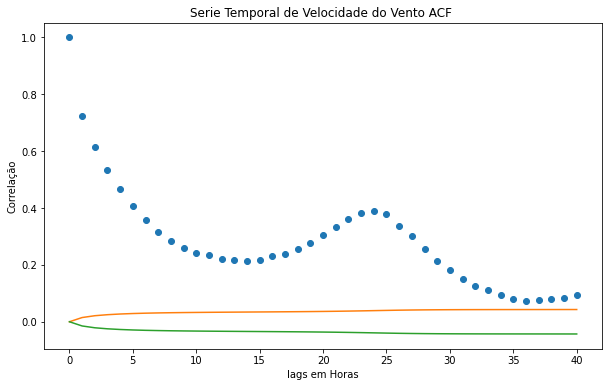

In [ ]:
#fazer :
#ACF -> Sem Diff e com Diff para achar o Q 
#PACF-> Sem Diff e com Diff para achar o P
#d = 0 , q0 -> ACF e p0-> PACF
# d = 1 (serie_ven.values[:-1] - serie_ven.values[1:]), q1 -> ACF e p1-> PACF
# ARIMA(p0,d0,q0)
# ARIMA(p1,d1,q1)

plt.plot(p2,'o')
plt.plot(c2[:,1]-p2)
plt.plot(c2[:,0]-p2)
plt.title('Serie Temporal de Velocidade do Vento ACF ')
plt.xlabel('lags em Horas')
plt.ylabel('Correlação')
plt.show()

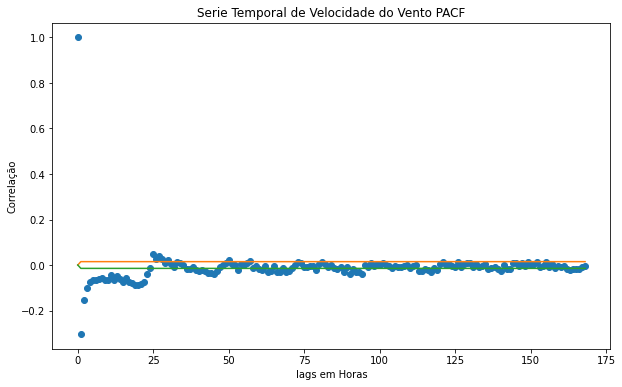

In [ ]:
import matplotlib.pyplot as plt
plt.plot(pd,'o')
plt.plot(cd[:,1]-pd)
plt.plot(cd[:,0]-pd)
plt.title('Serie Temporal de Velocidade do Vento PACF')
plt.xlabel('lags em Horas')
plt.ylabel('Correlação')
plt.show()

In [ ]:

cont_Ordem = 0
for _p,_c0,_c1 in zip(p,c[:,0],c[:,1]):  
  if _p > (_c1-_p) or _p < (_c0-_p):
    cont_Ordem+=1
  else:
    break
print(cont_Ordem)  

5


In [ ]:
cont = 0
lista_Relevancia = []
for _p,_c0,_c1 in zip(p,c[:,0],c[:,1]):
  if _p > (_c1-_p) or _p < (_c0-_p):
    lista_Relevancia.append(1)
    
  else:
    lista_Relevancia.append(0)
 


In [ ]:
#lista_Relevancia

In [ ]:
p1, c1 = pacf(serie_rad, alpha=0.05)
p3, c3 = acf(serie_rad, alpha=0.05)
p1d, c1d = pacf((serie_rad.values[:-1] - serie_rad.values[1:]), alpha=0.05,nlags=168)
p3d, c3d = acf((serie_rad.values[:-1] - serie_rad.values[1:]), alpha=0.05,nlags=168)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


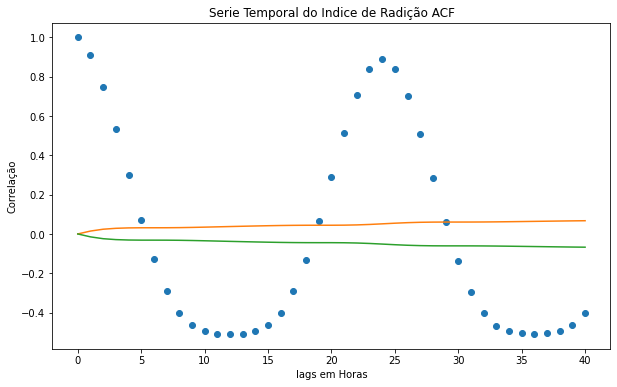

In [ ]:
plt.plot(p3,'o')
plt.plot(c3[:,1]-p3)
plt.plot(c3[:,0]-p3)
plt.title('Serie Temporal do Indice de Radição ACF')
plt.xlabel('lags em Horas')
plt.ylabel('Correlação')
plt.show()

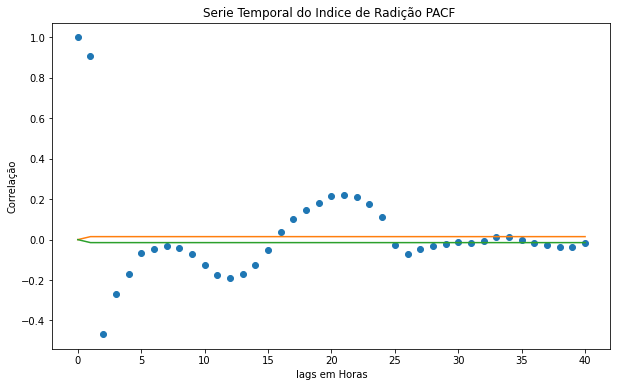

In [ ]:

plt.plot(p1,'o')
plt.plot(c1[:,1]-p1)
plt.plot(c1[:,0]-p1)
plt.title('Serie Temporal do Indice de Radição PACF ')
plt.xlabel('lags em Horas')
plt.ylabel('Correlação')
plt.show()

In [ ]:
#lcap ou ssAutoArima = low cost arima parameters or Super simple autoArima

#serie = serie temporal
#tipo_ACF_ou_PACF = acf ou pacf
#diferenciar = numero inteiro 0 ou 1
#Se você passou acf, o valor retornado é a ordem do "q"
#Se você passou pacf, o valor retornado é a ordem do "p"

def lcap (serie,difenciar,tipo_ACF_ou_PACF):
  from statsmodels.tsa.stattools import acf, pacf

  
  cont_Ordem = 0
  if difenciar == 0:
       p1, c1 = tipo_ACF_ou_PACF(serie, alpha=0.05)
       for _p,_c0,_c1 in zip(p1,c1[:,0],c1[:,1]):
          if _p > (_c1-_p) or _p < (_c0-_p):
            cont_Ordem+=1
          else:
            break
  elif difenciar == 1:
       p1, c1 = tipo_ACF_ou_PACF((serie.values[:-1] - serie.values[1:]), alpha=0.05)
       for _p,_c0,_c1 in zip(p1,c1[:,0],c1[:,1]):
          if _p > (_c1-_p) or _p < (_c0-_p):
            cont_Ordem+=1
          else:
            break
  
  else:
    print ("Difrenciacao Maxima permitida == 1 ")
  
  
  return cont_Ordem

In [ ]:
#ssAutoArima = Super simple autoArima

def ssArima(serie,d):
  start = time.time()
  q=lcap(serie,d,acf)
  p=lcap(serie,d,pacf)
  t = time.time() - start

  return print("Arimalcap",(p,d,q),t)

In [ ]:
ssArima(serie_ven,0)

Arimalcap (5, 0, 41) 0.14956164360046387


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


In [ ]:
ssArima(serie_rad,0)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Arimalcap (30, 0, 29) 0.1632986068725586


In [ ]:
ssArima(serie_ven,1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Arimalcap (24, 1, 4) 0.1517167091369629


In [ ]:
ssArima(serie_rad,1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Arimalcap (10, 1, 20) 0.1794757843017578


#Test ARIMA

In [ ]:
 from statsmodels.tsa.arima_model import ARIMA

In [ ]:
# from statsmodels.tsa.stattools import adfuller
# from numpy import log
# result = adfuller(serie_ven.dropna())
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
